In [289]:
# datasets from my GitHub
!git clone https://github.com/William-HTP/Google-Play-App-Reviews-Datasets.git

fatal: destination path 'Google-Play-App-Reviews-Datasets' already exists and is not an empty directory.


In [290]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [291]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
import math
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import pyplot as plt 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import XLNetTokenizer, XLNetModel, XLNetConfig, XLNetTokenizerFast
from transformers import XLNetForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

In [292]:
# tell pytorch to use the gpu if available
if torch.cuda.is_available():    
      
    DEVICE = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    DEVICE = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [293]:
df = pd.read_excel('/content/Google-Play-App-Reviews-Datasets/dataset_balanced_4000.xlsx')
pd.set_option('display.max_colwidth', None)
df

,ID,review,label,new_label,remove_all_stopwords,remove_some_stopwords,stemming,lemmatization
0,1,Not able to add freinds. It show something went wrong.. Recommend not to install it,bug report,0,able add freinds show something went wrong recommend install,not able add freinds show something went wrong recommend not install,not abl to add freind it show someth went wrong recommend not to instal it,not able to add freinds it show something went wrong recommend not to install it
1,2,Calls keep dropping for no reason and is super annoying,bug report,0,calls keep dropping reason super annoying,calls keep dropping no reason super annoying,call keep drop for no reason and is super annoy,call keep dropping for no reason and is super annoying
2,3,Can't access to my account solve this issue immediately,bug report,0,cant access account solve issue immediately,cant access account solve issue immediately,cant access to my account solv thi issu immedi,cant access to my account solve this issue immediately
3,4,"I don't know what's wrong with my own WhatsApp. Its not working. And if I want to sign up, it will just be bringing try again later. You guys should see to it.",bug report,0,dont know whats wrong whatsapp working want sign bringing try later guys see,dont know whats wrong whatsapp not working want sign up will bringing try again later guys should see,i dont know what wrong with my own whatsapp it not work and if i want to sign up it will just be bring tri again later you guy should see to it,i dont know whats wrong with my own whatsapp it not working and if i want to sign up it will just be bringing try again later you guy should see to it
4,5,Cannot record audio while taking video,bug report,0,cannot record audio taking video,cannot record audio taking video,cannot record audio while take video,cannot record audio while taking video
...,...,...,...,...,...,...,...,...
3995,3996,but can you just make the animation easier please !,feature request,1,make animation easier please,but can make animation easier please,but can you just make the anim easier pleas,but can you just make the animation easier please
3996,3997,While many third party app can view the file without internet. This app fails to deliver that.,feature request,1,many third party app view file without internet app fails deliver,many third party app can view file without internet app fails deliver,while mani third parti app can view the file without internet thi app fail to deliv that,while many third party app can view the file without internet this app fails to deliver that
3997,3998,No custom animation... Not good,feature request,1,custom animation good,no custom animation not good,no custom anim not good,no custom animation not good
3998,3999,Need more designs in slides,feature request,1,need designs slides,need more designs slides,need more design in slide,need more design in slide


In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     4000 non-null   int64 
 1   review                 4000 non-null   object
 2   label                  4000 non-null   object
 3   new_label              4000 non-null   int64 
 4   remove_all_stopwords   4000 non-null   object
 5   remove_some_stopwords  4000 non-null   object
 6   stemming               4000 non-null   object
 7   lemmatization          4000 non-null   object
dtypes: int64(2), object(6)
memory usage: 250.1+ KB


In [295]:
df['label'].value_counts()

bug report         1000
feature request    1000
rating             1000
user experience    1000
Name: label, dtype: int64

In [296]:
df = pd.DataFrame(df, columns = ["lemmatization", "new_label"])
df

,lemmatization,new_label
0,not able to add freinds it show something went wrong recommend not to install it,0
1,call keep dropping for no reason and is super annoying,0
2,cant access to my account solve this issue immediately,0
3,i dont know whats wrong with my own whatsapp it not working and if i want to sign up it will just be bringing try again later you guy should see to it,0
4,cannot record audio while taking video,0
...,...,...
3995,but can you just make the animation easier please,1
3996,while many third party app can view the file without internet this app fails to deliver that,1
3997,no custom animation not good,1
3998,need more design in slide,1


In [297]:
# df.rename(columns={'remove_all_stopwords':'review'})
df.columns = ['review','new_label']
df

,review,new_label
0,not able to add freinds it show something went wrong recommend not to install it,0
1,call keep dropping for no reason and is super annoying,0
2,cant access to my account solve this issue immediately,0
3,i dont know whats wrong with my own whatsapp it not working and if i want to sign up it will just be bringing try again later you guy should see to it,0
4,cannot record audio while taking video,0
...,...,...
3995,but can you just make the animation easier please,1
3996,while many third party app can view the file without internet this app fails to deliver that,1
3997,no custom animation not good,1
3998,need more design in slide,1


In [298]:
# Split data into training and test sets
train_df, test_df = train_test_split(df, test_size = 0.2, random_state=42)

In [299]:
df = pd.DataFrame(train_df, columns = ["review", "new_label"])
df

,review,new_label
3994,it is a very nice software because of it ability to easily express idea and thought in a way that everyone can understand it would be great if this program had more graphic feature such a brain map and concept map,1
423,i can t login dat my problem,0
2991,this a great tool for a rapid lab consultation,3
1221,it difficult to read the subtitle especially if it very bright pls bring back the old one having a hard time to understand what you watch especially for foreign one,1
506,good interface and function but it is extremely laggy on my samsung a20 even have to wait 23 minute to turn on and off voice those two star for messaging but the app simply isnt capable of doing what it ment to do,0
...,...,...
1130,pls give u a feature where we can negatively react to message we are sent itd be so fun and silly and make the app increase in enjoyment by 70,1
1294,i just wish there were more way to get the gold bar,1
860,facebook not responding in my device,0
3507,i like it although they keep forcing you to rate the app it so annoying,3


In [300]:
df_test = pd.DataFrame(test_df, columns = ["review", "new_label"])
df_test

,review,new_label
555,anytime im watching ad it log me out automatically,0
3491,too many ad very much disturbing,3
527,emoticon list it opening after 56 second or more when i need during a conversation on 5g or wifi fiber i receive notification for lost message after four day better not send any notification,0
3925,i like the idea of dropbox but the user friendliness is extremely lacking,3
2989,i have used this app for over 8 month and is by far the best golf gps for the money i had a sky caddie before and it wa not half a good a this app dont waste your money on any of the annual due gps unit buy this app and have everything you need i have the iphone 4 and only us about half the battery during a 4 12 to 5 12 hour round turn off your wifi if it is using more battery life than that anyway must have for all serious golfer,3
...,...,...
1922,getting lower and we still pay for itplease make the picture view adjustable since lage device took roll,1
865,not showing friend suggestion,0
3943,enjoy playing this game but it could give more out like free thing if you complete so many level you might get 10 extra life something like that but overall good game,1
1642,i like the new feature that make the product more stanzalike i still would like to be able to go directly from the library list to the current place in any given book without having to pas by the toc page,1


In [301]:
# Name of the pre-trained model to use
model_name = 'xlnet-base-cased'

# Load transformers config and set number of classes
config = XLNetConfig.from_pretrained(model_name)
config.num_labels = 4

# Load XLNet tokenizer
tokenizer = XLNetTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_name, config=config)
model = XLNetForSequenceClassification.from_pretrained(model_name, config=config)

CUDA_LAUNCH_BLOCKING=1
model = model.to(DEVICE)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [302]:
text = "Lupakan Premier League, Liverpool Kini Fokus Dapatkan Trofi Liga Champion"
token = tokenizer.tokenize(text)
token_ids = tokenizer.convert_tokens_to_ids(token)
token_encode = tokenizer.encode(text, add_special_tokens = True)
token_decode = tokenizer.decode(token_encode)

print("Original : ", text)
print("Token : ", token)
print("Token Ids: ", token_ids)
print("Token Encode: ", token_encode)
print("Token Decode: ", token_decode)

Original :  Lupakan Premier League, Liverpool Kini Fokus Dapatkan Trofi Liga Champion
Token :  ['▁Lu', 'pak', 'an', '▁Premier', '▁League', ',', '▁Liverpool', '▁Kin', 'i', '▁F', 'oku', 's', '▁Da', 'pat', 'kan', '▁Tro', 'fi', '▁Liga', '▁Champion']
Token Ids:  [2031, 21185, 262, 3995, 925, 19, 6851, 7337, 150, 518, 16845, 23, 2994, 9059, 5944, 5633, 2265, 18985, 11383]
Token Encode:  [2031, 21185, 262, 3995, 925, 19, 6851, 7337, 150, 518, 16845, 23, 2994, 9059, 5944, 5633, 2265, 18985, 11383, 4, 3]
Token Decode:  Lupakan Premier League, Liverpool Kini Fokus Dapatkan Trofi Liga Champion<sep><cls>


In [303]:
contents = df.review.values
labels = df.new_label.values   

contents_test = df_test.review.values
labels_test = df_test.new_label.values 

In [304]:
input_ids = []
input_ids_test = []

inputs_ids, attention_mask = [],[]
inputs_ids_test, attention_mask_test = [],[]

for sent in contents:
    encoded_sent = tokenizer.encode_plus(sent, 
                                        add_special_tokens=True,
                                        max_length=256, 
                                        return_tensors='pt', 
                                        return_token_type_ids=False, 
                                        return_attention_mask=True, 
                                        pad_to_max_length=True)
    input_ids.append(encoded_sent)


for sent in contents_test:
    encoded_sent = tokenizer.encode_plus(sent,
                                        add_special_tokens=True,
                                        max_length=256, 
                                        return_tensors='pt', 
                                        return_token_type_ids=False, 
                                        return_attention_mask=True, 
                                        pad_to_max_length=True)
    input_ids_test.append(encoded_sent)

for item in input_ids:
    for key in item:
        if(key == "input_ids"):
            inputs_ids.append((item[key]).numpy().tolist())
        elif(key == "attention_mask"):
            attention_mask.append((item[key]).numpy().tolist())

for item in input_ids_test:
    for key in item:
        if(key == "input_ids"):
            inputs_ids_test.append((item[key]).numpy().tolist())
        elif(key == "attention_mask"):
            attention_mask_test.append((item[key]).numpy().tolist())         

inputs_ids = [item for sublist in inputs_ids for item in sublist]
attention_mask = [item for sublist in attention_mask for item in sublist]

inputs_ids_test = [item for sublist in inputs_ids_test for item in sublist]
attention_mask_test = [item for sublist in attention_mask_test for item in sublist] 

train_input, validation_input, train_labels, validation_labels = train_test_split(inputs_ids,
                                                                      labels,
                                                                      random_state=2017,
                                                                      test_size=0.2)
train_mask, validation_mask, _, _  = train_test_split(attention_mask,
                                               labels,
                                               random_state=2017,
                                               test_size=0.2)

test_input = inputs_ids_test
test_mask = attention_mask_test
test_labels = labels_test

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [305]:
print(np.shape(train_input))

(2560, 256)


In [306]:
batch_size = 16

train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [307]:
epochs = 5

#lr = 0.0005
optimizer = torch.optim.Adamax(
    model.parameters(),
    lr = 1e-4
)

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [308]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [309]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [310]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

train_loss_values = []
train_acc_values = []
eval_loss_values = []
eval_acc_values = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

    print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
    print("Training...")

    t0 = time.time()

    total_loss = 0
    train_accuracy = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        
        # Progress update every 40 batches
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(DEVICE)
        b_input_mask = batch[1].to(DEVICE)
        b_labels = batch[2].to(DEVICE)

        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()

        loss.backward()

        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    train_loss = total_loss / len(train_dataloader)
    train_loss_values.append(train_loss)
    train_acc = train_accuracy / len(train_dataloader)
    train_acc_values.append(train_acc)

    print("   Training loss : {0:.5f}".format(train_loss))
    print("   Training acc  : {0:.5f}".format(train_acc))
    print("   Training took : {:}".format(format_time(time.time() - t0)))


    # ===================================
    #             Validation
    # ===================================

    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    e_loss = 0

    for batch in validation_dataloader:

        batch = tuple(t.to(DEVICE) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            loss = outputs[0]
            e_loss += loss.item()

            logits = outputs[1]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            eval_accuracy += tmp_eval_accuracy

            eval_loss = total_loss / len(validation_dataloader)
    eval_loss_values.append(eval_loss)
    eval_acc = eval_accuracy / len(validation_dataloader)
    eval_acc_values.append(eval_acc)

    print("   Validation loss : {0:.5f}".format(eval_loss))
    print("   Validation acc  : {0:.5f}".format(eval_acc))
    print("   Validation took : {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 5 =======
Training...
Batch    40 of   160.     Elapsed: 0:00:43
Batch    80 of   160.     Elapsed: 0:01:26
Batch   120 of   160.     Elapsed: 0:02:08
   Training loss : 1.08910
   Training acc  : 0.50898
   Training took : 0:02:51
Running Validation...
   Validation loss : 4.35641
   Validation acc  : 0.63906
   Validation took : 0:00:20
======= Epoch 2 / 5 =======
Training...
Batch    40 of   160.     Elapsed: 0:00:43
Batch    80 of   160.     Elapsed: 0:01:26
Batch   120 of   160.     Elapsed: 0:02:08
   Training loss : 0.71334
   Training acc  : 0.73477
   Training took : 0:02:51
Running Validation...
   Validation loss : 2.85335
   Validation acc  : 0.69844
   Validation took : 0:00:20
======= Epoch 3 / 5 =======
Training...
Batch    40 of   160.     Elapsed: 0:00:43
Batch    80 of   160.     Elapsed: 0:01:26
Batch   120 of   160.     Elapsed: 0:02:08
   Training loss : 0.52294
   Training acc  : 0.80469
   Training took : 0:02:51
Running Validation...
   Validat

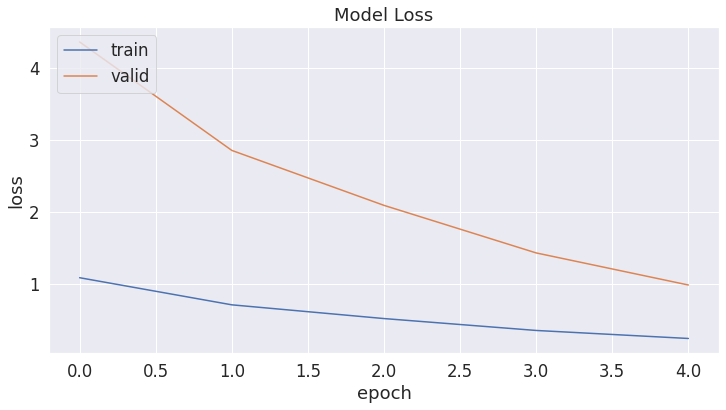

In [311]:
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(train_loss_values)
plt.plot(eval_loss_values)
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

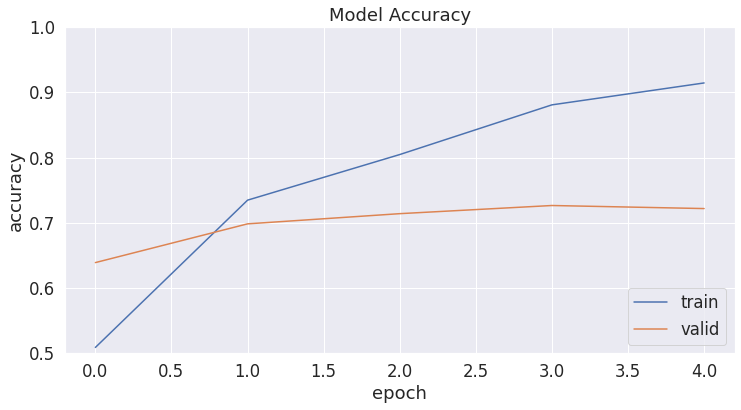

In [312]:
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(train_acc_values)
plt.plot(eval_acc_values)
plt.title('Model Accuracy')
plt.ylim(0.5, 1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

In [313]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(DEVICE) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
print('DONE.')

Predicting labels for 800 test sentences...
DONE.


In [314]:
predictions_labels = [item for subitem in predictions for item in subitem]

predictions_labels = np.argmax(predictions_labels, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(predictions_labels, flat_true_labels))

print(confusion_matrix(flat_true_labels, predictions_labels))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       230
           1       0.75      0.76      0.76       210
           2       0.64      0.79      0.71       160
           3       0.68      0.61      0.65       200

    accuracy                           0.73       800
   macro avg       0.73      0.73      0.73       800
weighted avg       0.74      0.73      0.73       800

[[177  12   6  14]
 [ 23 159   7  22]
 [ 12  19 127  41]
 [ 18  20  20 123]]


In [94]:
def plot_confusion_matrix(y_preds, y_true, labels=None):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
    plt.title("Normalized confusion matrix")
    plt.show()

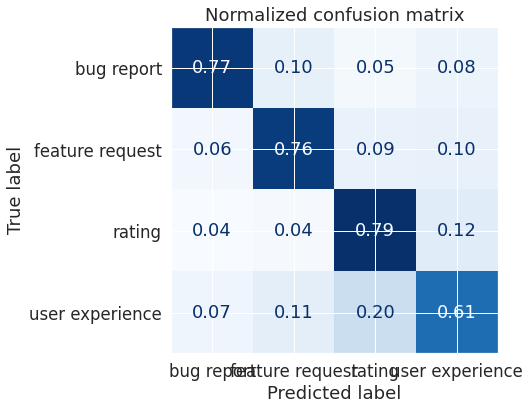

In [315]:
a = ["bug report","feature request","rating","user experience"]
plot_confusion_matrix(flat_true_labels, predictions_labels ,labels=a)